In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps


M = 5  # Maximum number of nodes that can be polled
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.95  # dEWMA parameter for state value
beta_2 = 0.01 # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Track the number of times each category is pulled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2



# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Dynamic Penalty Update algorithm based on Whittle indices
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Convert dictionary values to a list of whittle indices, handling any NaN values
    c_values = []
    for v in whittle_indices.values():
        if np.isnan(v):
            c_values.append(-float('inf'))  # Treat NaN as negative infinity (won't be polled)
        else:
            c_values.append(v)
    
    # Identify the set ℰ of nodes where c_i > λ(t)
    eligible_nodes = [i for i, c_i in enumerate(c_values) if c_i > current_lambda]
    
    # If |ℰ| ≤ M, no penalty update needed
    if len(eligible_nodes) <= M:
        return current_lambda
    
    # Sort the c_i values in descending order
    sorted_c_values = sorted(c_values, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_c_values[M-1]
    
    # Update penalty to the M-th value
    new_lambda = M_th_value
    
    return new_lambda

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, M, theta, penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations - with safety checks for NaN/Inf values
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            
            # Calculate the Whittle index with safeguards against invalid values
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Update the dynamic penalty (λ) using the algorithm
        aoii_penalty = dynamic_penalty_update(whittle_indices, M, aoii_penalty)
        penalty_values.append(aoii_penalty)
        
        # Step 3: Select nodes to poll based on the updated penalty
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= aoii_penalty]
        nodes_polled_count.append(len(nodes_to_poll))

        # Step 4: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update (ensure at least 1)

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1

   

    return  category_counts, penalty_values, nodes_polled_count

# Run the simulation with dynamic penalty
category_pulled_counts, penalty_values, nodes_polled_count = run_simulation_whittle_aoii_dynamic_penalty(
    pivot_df, columns, M, theta, penalty
)

# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_pulled_counts.items():
    print(f"{category}: {count} times")




Transmission Count by Category:
Category A: 2805 times
Category B: 2801 times
Category C: 2780 times


Running simulations for different values of M...
--------------------------------------------------------------------------------
M    Total Packets  MSE            RMSE           MAE            
--------------------------------------------------------------------------------
Running simulation with M = 1...
1    1,841          78.870154      8.880887       7.246654       
Running simulation with M = 2...
2    3,327          14.782319      3.844778       2.856406       
Running simulation with M = 5...
5    6,555          2.597759       1.611757       1.166913       
Running simulation with M = 10...
10   9,203          1.862220       1.364632       0.969803       
--------------------------------------------------------------------------------


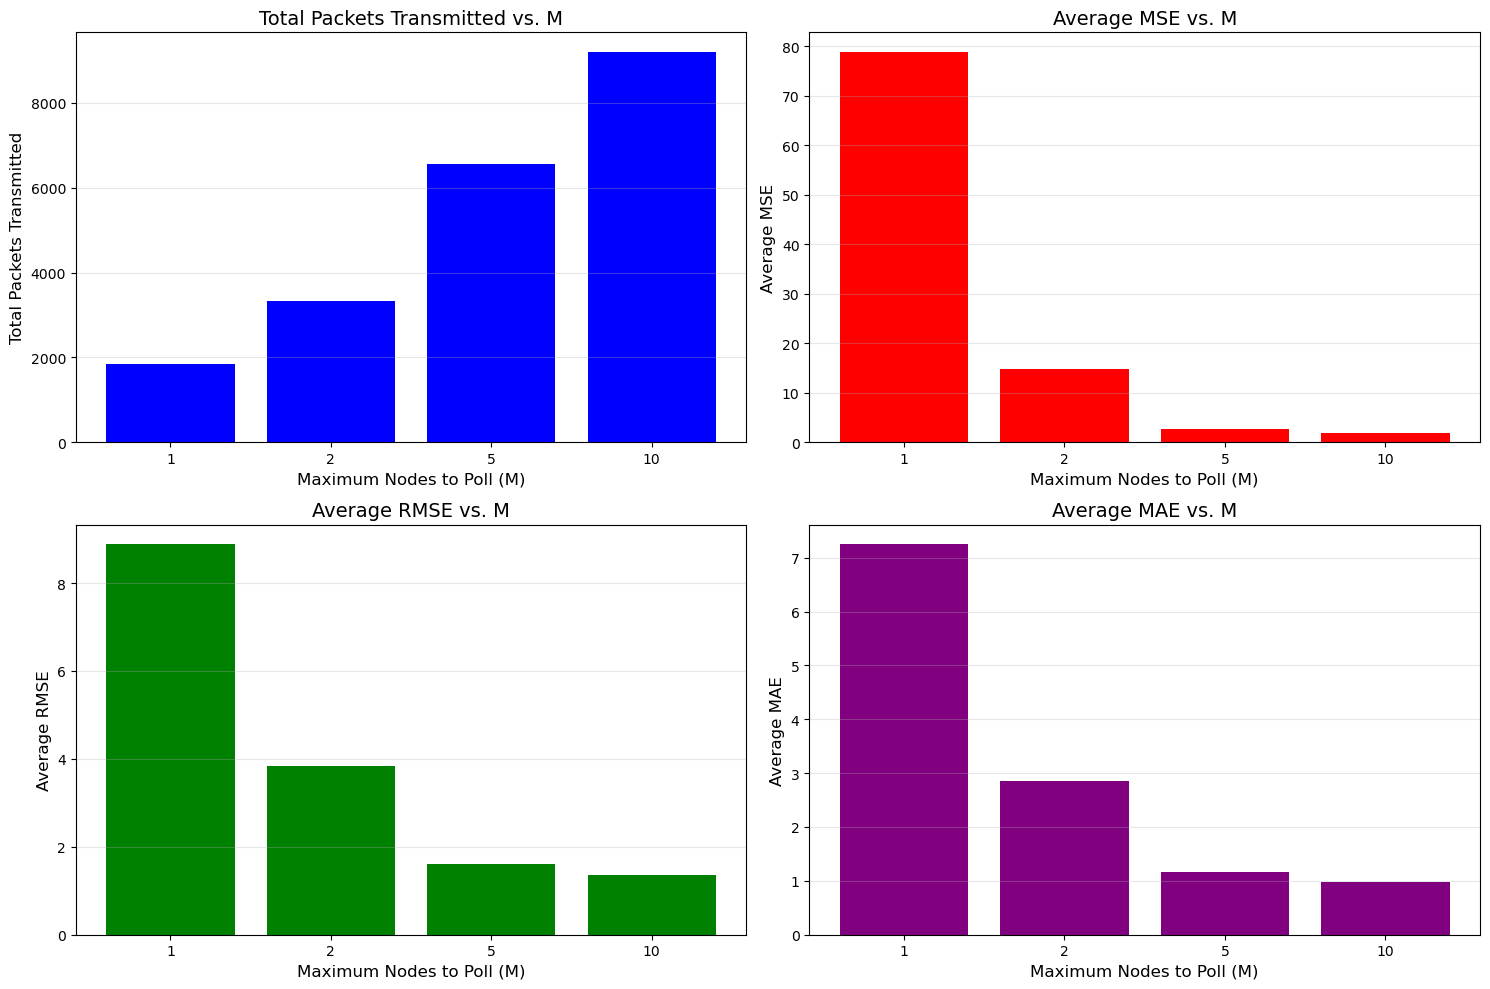


Results saved to 'm_comparison_results.csv'


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
#pivot_df = pd.read_csv("simulated_environment_data.csv")
pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps


penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.95  # dEWMA parameter for state value
beta_2 = 0.01  # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Dynamic Penalty Update algorithm based on Whittle indices
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Convert dictionary values to a list of whittle indices, handling any NaN values
    c_values = []
    for v in whittle_indices.values():
        if np.isnan(v):
            c_values.append(-float('inf'))  # Treat NaN as negative infinity (won't be polled)
        else:
            c_values.append(v)
    
    # Identify the set ℰ of nodes where c_i > λ(t)
    eligible_nodes = [i for i, c_i in enumerate(c_values) if c_i > current_lambda]
    
    # If |ℰ| ≤ M, no penalty update needed
    if len(eligible_nodes) <= M:
        return current_lambda
    
    # Sort the c_i values in descending order
    sorted_c_values = sorted(c_values, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_c_values[M-1]
    
    # Update penalty to the M-th value
    new_lambda = M_th_value
    
    return new_lambda

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, M, theta, penalty):
    # Track the number of times each category is pulled
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}
    total_polls = 0  # Track total number of polls across all nodes
    
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero
    
    # Track estimated values and MSE
    estimated_values = {col: np.zeros(len(pivot_df)) for col in columns}
    mse_per_timestep = []
    
    # Initialize estimated values with initial state
    for col in columns:
        estimated_values[col][0] = state_node[col][0]

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations - with safety checks for NaN/Inf values
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            
            # Calculate the Whittle index with safeguards against invalid values
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Update the dynamic penalty (λ) using the algorithm
        aoii_penalty = dynamic_penalty_update(whittle_indices, M, aoii_penalty)
        penalty_values.append(aoii_penalty)
        
        # Step 3: Select nodes to poll based on the updated penalty
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= aoii_penalty]
        nodes_polled_count.append(len(nodes_to_poll))
        total_polls += len(nodes_to_poll)  # Update total polls count

        # Step 4: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update (ensure at least 1)

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1
        
        # Step 5: Update estimated values for all nodes (polled and non-polled)
        for col in columns:
            if col in nodes_to_poll:
                # For polled nodes, use the actual measurement
                estimated_values[col][t] = float(pivot_df.loc[t, col])
            else:
                # For non-polled nodes, use the predicted value from the state model
                last_state_value, last_rate_of_change = state_node[col]
                delta_t_since_last = max(min_delta_t, t - last_update_times[col])
                # Predict using the linear model: x(t) = x(t-1) + rate * delta_t
                estimated_values[col][t] = last_state_value + last_rate_of_change * delta_t_since_last
        
        # Calculate MSE for this time step (overall)
        true_values = np.array([pivot_df.loc[t, col] for col in columns])
        estimated = np.array([estimated_values[col][t] for col in columns])
        current_mse = mean_squared_error(true_values, estimated)
        mse_per_timestep.append(current_mse)

    # Calculate average MSE across all time steps
    avg_mse = np.mean(mse_per_timestep)
    
    # Additional calculation of RMSE and MAE
    avg_rmse = np.sqrt(avg_mse)
    
    # Calculate MAE manually since we already have the estimated values
    total_abs_error = 0
    count = 0
    for t in range(len(pivot_df)):
        for col in columns:
            total_abs_error += abs(pivot_df.loc[t, col] - estimated_values[col][t])
            count += 1
    avg_mae = total_abs_error / count

    return {
        'total_polls': total_polls,
        'category_counts': category_counts,
        'avg_mse': avg_mse,
        'avg_rmse': avg_rmse,
        'avg_mae': avg_mae
    }

# Create a loop to run the simulation with different M values
m_values = [1, 2, 5, 10]
results = {}

print("Running simulations for different values of M...")
print("-" * 80)
print(f"{'M':<5}{'Total Packets':<15}{'MSE':<15}{'RMSE':<15}{'MAE':<15}")
print("-" * 80)

for m in m_values:
    print(f"Running simulation with M = {m}...")
    result = run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, m, theta, penalty)
    results[m] = result
    
    # Print results for this M value
    print(f"{m:<5}{result['total_polls']:<15,.0f}{result['avg_mse']:<15.6f}{result['avg_rmse']:<15.6f}{result['avg_mae']:<15.6f}")

print("-" * 80)

# Plot the results
plt.figure(figsize=(15, 10))

# Plot 1: Total packets vs M
plt.subplot(2, 2, 1)
plt.bar([str(m) for m in m_values], [results[m]['total_polls'] for m in m_values], color='blue')
plt.xlabel('Maximum Nodes to Poll (M)', fontsize=12)
plt.ylabel('Total Packets Transmitted', fontsize=12)
plt.title('Total Packets Transmitted vs. M', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Plot 2: MSE vs M
plt.subplot(2, 2, 2)
plt.bar([str(m) for m in m_values], [results[m]['avg_mse'] for m in m_values], color='red')
plt.xlabel('Maximum Nodes to Poll (M)', fontsize=12)
plt.ylabel('Average MSE', fontsize=12)
plt.title('Average MSE vs. M', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Plot 3: RMSE vs M
plt.subplot(2, 2, 3)
plt.bar([str(m) for m in m_values], [results[m]['avg_rmse'] for m in m_values], color='green')
plt.xlabel('Maximum Nodes to Poll (M)', fontsize=12)
plt.ylabel('Average RMSE', fontsize=12)
plt.title('Average RMSE vs. M', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Plot 4: MAE vs M
plt.subplot(2, 2, 4)
plt.bar([str(m) for m in m_values], [results[m]['avg_mae'] for m in m_values], color='purple')
plt.xlabel('Maximum Nodes to Poll (M)', fontsize=12)
plt.ylabel('Average MAE', fontsize=12)
plt.title('Average MAE vs. M', fontsize=14)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("m_comparison_metrics.png", dpi=300)
plt.show()

# Create a dataframe with all results and save to CSV
results_df = pd.DataFrame({
    'M': m_values,
    'Total_Packets': [results[m]['total_polls'] for m in m_values],
    'MSE': [results[m]['avg_mse'] for m in m_values],
    'RMSE': [results[m]['avg_rmse'] for m in m_values],
    'MAE': [results[m]['avg_mae'] for m in m_values],
    'Category_A_Polls': [results[m]['category_counts']['Category A'] for m in m_values],
    'Category_B_Polls': [results[m]['category_counts']['Category B'] for m in m_values],
    'Category_C_Polls': [results[m]['category_counts']['Category C'] for m in m_values]
})

results_df.to_csv("m_comparison_results.csv", index=False)
print("\nResults saved to 'm_comparison_results.csv'")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.8  # dEWMA parameter for state value
beta_2 = 0.01  # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Function to extract numeric node ID from column names dynamically, ensuring valid extraction
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Dynamic Penalty Update algorithm based on Whittle indices
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Convert dictionary values to a list of whittle indices, handling any NaN values
    c_values = []
    for v in whittle_indices.values():
        if np.isnan(v):
            c_values.append(-float('inf'))  # Treat NaN as negative infinity (won't be polled)
        else:
            c_values.append(v)
    
    # Identify the set ℰ of nodes where c_i > λ(t)
    eligible_nodes = [i for i, c_i in enumerate(c_values) if c_i > current_lambda]
    
    # If |ℰ| ≤ M, no penalty update needed
    if len(eligible_nodes) <= M:
        return current_lambda
    
    # Sort the c_i values in descending order
    sorted_c_values = sorted(c_values, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_c_values[M-1]
    
    # Update penalty to the M-th value
    new_lambda = M_th_value
    
    return new_lambda

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, M, theta, penalty):
    # Track the number of times each category is pulled
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}
    total_polls = 0  # Track total number of polls across all nodes
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero
    
    # Track estimated values and MSE
    estimated_values = {col: np.zeros(len(pivot_df)) for col in columns}
    mse_per_timestep = []
    
    # Initialize estimated values with initial state
    for col in columns:
        estimated_values[col][0] = state_node[col][0]

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations - with safety checks for NaN/Inf values
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            
            # Calculate the Whittle index with safeguards against invalid values
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Update the dynamic penalty (λ) using the algorithm
        aoii_penalty = dynamic_penalty_update(whittle_indices, M, aoii_penalty)
        penalty_values.append(aoii_penalty)
        
        # Step 3: Select nodes to poll based on the updated penalty
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= aoii_penalty]
        nodes_polled_count.append(len(nodes_to_poll))
        total_polls += len(nodes_to_poll)  # Update total polls count

        # Step 4: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update (ensure at least 1)

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Extract node ID dynamically and categorize
            node_id = extract_node_id(col)
            if node_id is not None:
                if 1 <= node_id <= 10:
                    category_counts['Category A'] += 1
                elif 11 <= node_id <= 20:
                    category_counts['Category B'] += 1
                elif 21 <= node_id <= 30:
                    category_counts['Category C'] += 1
        
        # Step 5: Update estimated values for all nodes (polled and non-polled)
        for col in columns:
            if col in nodes_to_poll:
                # For polled nodes, use the actual measurement
                estimated_values[col][t] = float(pivot_df.loc[t, col])
            else:
                # For non-polled nodes, use the predicted value from the state model
                last_state_value, last_rate_of_change = state_node[col]
                delta_t_since_last = max(min_delta_t, t - last_update_times[col])
                # Predict using the linear model: x(t) = x(t-1) + rate * delta_t
                estimated_values[col][t] = last_state_value + last_rate_of_change * delta_t_since_last
        
        # Calculate MSE for this time step (overall)
        true_values = np.array([pivot_df.loc[t, col] for col in columns])
        estimated = np.array([estimated_values[col][t] for col in columns])
        current_mse = mean_squared_error(true_values, estimated)
        mse_per_timestep.append(current_mse)

    # Calculate average MSE across all time steps
    avg_mse = np.mean(mse_per_timestep)
    
    # Additional calculation of RMSE and MAE
    avg_rmse = np.sqrt(avg_mse)
    
    # Calculate MAE manually since we already have the estimated values
    total_abs_error = 0
    count = 0
    for t in range(len(pivot_df)):
        for col in columns:
            total_abs_error += abs(pivot_df.loc[t, col] - estimated_values[col][t])
            count += 1
    avg_mae = total_abs_error / count

    return {
        'total_polls': total_polls,
        'category_counts': category_counts,
        'avg_mse': avg_mse,
        'avg_rmse': avg_rmse,
        'avg_mae': avg_mae
    }

# Create a loop to run the simulation with different M values
m_values = [1, 2, 5, 10]
results = {}

print("Running simulations for different values of M...")
print("-" * 80)
print(f"{'M':<5}{'Status':<20}")
print("-" * 80)

for m in m_values:
    print(f"{m:<5}{'Running simulation...':<20}", end='', flush=True)
    result = run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, m, theta, penalty)
    results[m] = result
    print(f"Completed")

print("-" * 80)

# Skip plotting and just print the detailed results
print("\nDetailed Results for Different M Values:")
print("-" * 80)
print(f"{'M':<5}{'Total Packets':<15}{'MSE':<15}{'RMSE':<15}{'MAE':<15}{'Cat A Polls':<15}{'Cat B Polls':<15}{'Cat C Polls':<15}")
print("-" * 80)

for m in m_values:
    result = results[m]
    cat_counts = result['category_counts']
    print(f"{m:<5}{result['total_polls']:<15,.0f}{result['avg_mse']:<15.6f}{result['avg_rmse']:<15.6f}{result['avg_mae']:<15.6f}{cat_counts['Category A']:<15}{cat_counts['Category B']:<15}{cat_counts['Category C']:<15}")

print("-" * 80)

# Create a dataframe with all results and save to CSV
results_df = pd.DataFrame({
    'M': m_values,
    'Total_Packets': [results[m]['total_polls'] for m in m_values],
    'MSE': [results[m]['avg_mse'] for m in m_values],
    'RMSE': [results[m]['avg_rmse'] for m in m_values],
    'MAE': [results[m]['avg_mae'] for m in m_values],
    'Category_A_Polls': [results[m]['category_counts']['Category A'] for m in m_values],
    'Category_B_Polls': [results[m]['category_counts']['Category B'] for m in m_values],
    'Category_C_Polls': [results[m]['category_counts']['Category C'] for m in m_values]
})

results_df.to_csv("m_comparison_results.csv", index=False)
print("\nResults saved to 'm_comparison_results.csv'")




Running simulations for different values of M...
--------------------------------------------------------------------------------
M    Status              
--------------------------------------------------------------------------------
1    Running simulation...Completed
2    Running simulation...Completed
5    Running simulation...Completed
10   Running simulation...Completed
--------------------------------------------------------------------------------

Detailed Results for Different M Values:
--------------------------------------------------------------------------------
M    Total Packets  MSE            RMSE           MAE            Cat A Polls    Cat B Polls    Cat C Polls    
--------------------------------------------------------------------------------
1    1,139          33576.152643   183.237967     166.189820     50             139            950            
2    2,236          3682.350637    60.682375      55.466995      150            359            1727           
5

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 10000 time steps

# Parameters
reward = 0.5
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values

# Set parameters
beta_1 = 0.98 # dEWMA parameter for state value
beta_2 = 0.0001  # dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Create a mapping of columns to categories
column_categories = {}
for col in columns:
    node_id = ''.join(filter(str.isdigit, col))
    if node_id:
        node_id = int(node_id)
        if 1 <= node_id <= 10:
            column_categories[col] = 'Category A'
        elif 11 <= node_id <= 20:
            column_categories[col] = 'Category B'
        elif 21 <= node_id <= 30:
            column_categories[col] = 'Category C'
    else:
        column_categories[col] = 'Uncategorized'

# Group columns by category
category_columns = {
    'Category A': [col for col, cat in column_categories.items() if cat == 'Category A'],
    'Category B': [col for col, cat in column_categories.items() if cat == 'Category B'],
    'Category C': [col for col, cat in column_categories.items() if cat == 'Category C'],
    'Uncategorized': [col for col, cat in column_categories.items() if cat == 'Uncategorized']
}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Dynamic Penalty Update algorithm based on Whittle indices
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Convert dictionary values to a list of whittle indices, handling any NaN values
    c_values = []
    for v in whittle_indices.values():
        if np.isnan(v):
            c_values.append(-float('inf'))  # Treat NaN as negative infinity (won't be polled)
        else:
            c_values.append(v)
    
    # Identify the set ℰ of nodes where c_i > λ(t)
    eligible_nodes = [i for i, c_i in enumerate(c_values) if c_i > current_lambda]
    
    # If |ℰ| ≤ M, no penalty update needed
    if len(eligible_nodes) <= M:
        return current_lambda
    
    # Sort the c_i values in descending order
    sorted_c_values = sorted(c_values, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_c_values[M-1]
    
    # Update penalty to the M-th value
    new_lambda = M_th_value
    
    return new_lambda

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, M, theta, penalty):
    # Track the number of times each category is pulled
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0, 'Uncategorized': 0}
    total_polls = 0  # Track total number of polls across all nodes
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero
    
    # Track estimated values and MSE
    estimated_values = {col: np.zeros(len(pivot_df)) for col in columns}
    
    # Track errors separately for each category
    category_errors = {
        cat: {'squared_errors': [], 'absolute_errors': []} 
        for cat in ['Category A', 'Category B', 'Category C', 'Uncategorized', 'Overall']
    }
    
    # Initialize estimated values with initial state
    for col in columns:
        estimated_values[col][0] = state_node[col][0]

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations - with safety checks for NaN/Inf values
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            
            # Calculate the Whittle index with safeguards against invalid values
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Update the dynamic penalty (λ) using the algorithm
        aoii_penalty = dynamic_penalty_update(whittle_indices, M, aoii_penalty)
        penalty_values.append(aoii_penalty)
        
        # Step 3: Select nodes to poll based on the updated penalty
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= aoii_penalty]
        nodes_polled_count.append(len(nodes_to_poll))
        total_polls += len(nodes_to_poll)  # Update total polls count

        # Step 4: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update (ensure at least 1)

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Count polling by category
            cat = column_categories.get(col, 'Uncategorized')
            category_counts[cat] += 1
        
        # Step 5: Update estimated values for all nodes (polled and non-polled)
        for col in columns:
            if col in nodes_to_poll:
                # For polled nodes, use the actual measurement
                estimated_values[col][t] = float(pivot_df.loc[t, col])
            else:
                # For non-polled nodes, use the predicted value from the state model
                last_state_value, last_rate_of_change = state_node[col]
                delta_t_since_last = max(min_delta_t, t - last_update_times[col])
                # Predict using the linear model: x(t) = x(t-1) + rate * delta_t
                estimated_values[col][t] = last_state_value + last_rate_of_change * delta_t_since_last
        
        # Calculate errors for each category
        for category, cat_columns in category_columns.items():
            if cat_columns:  # Skip empty categories
                # Get true and estimated values for this category
                true_cat_values = np.array([pivot_df.loc[t, col] for col in cat_columns])
                est_cat_values = np.array([estimated_values[col][t] for col in cat_columns])
                
                # Calculate squared errors and absolute errors
                squared_errors = (true_cat_values - est_cat_values) ** 2
                absolute_errors = np.abs(true_cat_values - est_cat_values)
                
                # Store errors
                category_errors[category]['squared_errors'].extend(squared_errors)
                category_errors[category]['absolute_errors'].extend(absolute_errors)
        
        # Calculate overall errors (across all columns)
        true_values = np.array([pivot_df.loc[t, col] for col in columns])
        est_values = np.array([estimated_values[col][t] for col in columns])
        
        squared_errors = (true_values - est_values) ** 2
        absolute_errors = np.abs(true_values - est_values)
        
        category_errors['Overall']['squared_errors'].extend(squared_errors)
        category_errors['Overall']['absolute_errors'].extend(absolute_errors)

    # Calculate final error metrics for each category
    error_metrics = {}
    for category, errors in category_errors.items():
        if errors['squared_errors']:  # Skip empty categories
            # Calculate MSE, RMSE, and MAE
            mse = np.mean(errors['squared_errors'])
            rmse = np.sqrt(mse)
            mae = np.mean(errors['absolute_errors'])
            
            error_metrics[category] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae
            }

    return {
        'total_polls': total_polls,
        'category_counts': category_counts,
        'error_metrics': error_metrics
    }

# Create a loop to run the simulation with different M values
m_values = [1, 2, 5, 10]
results = {}

print("Running simulations for different values of M...")
print("-" * 80)
print(f"{'M':<5}{'Status':<20}")
print("-" * 80)

for m in m_values:
    print(f"{m:<5}{'Running simulation...':<20}", end='', flush=True)
    result = run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, m, theta, penalty)
    results[m] = result
    print(f"Completed")

print("-" * 80)

# Print detailed results showing RMSE and MAE for each category
print("\nDetailed Error Metrics by Category:")
print("-" * 100)
header = f"{'M':<5}{'Category':<15}{'RMSE':<15}{'MAE':<15}{'Polls':<15}"
print(header)
print("-" * 100)

# First print overall results for each M
for m in m_values:
    result = results[m]
    metrics = result['error_metrics']
    
    # Print overall metrics
    overall = metrics.get('Overall', {'RMSE': 0, 'MAE': 0})
    total_polls = result['total_polls']
    print(f"{m:<5}{'Overall':<15}{overall['RMSE']:<15.6f}{overall['MAE']:<15.6f}{total_polls:<15,d}")

    # Print category-specific metrics
    for category in ['Category A', 'Category B', 'Category C']:
        if category in metrics:
            cat_metrics = metrics[category]
            cat_polls = result['category_counts'].get(category, 0)
            print(f"{'':<5}{category:<15}{cat_metrics['RMSE']:<15.6f}{cat_metrics['MAE']:<15.6f}{cat_polls:<15,d}")
    
    # Add a separator between different M values
    print("-" * 100)

# Create a dataframe with all results and save to CSV
results_data = []
for m in m_values:
    result = results[m]
    metrics = result['error_metrics']
    
    # Overall metrics
    overall = metrics.get('Overall', {'RMSE': 0, 'MAE': 0})
    row = {
        'M': m,
        'Category': 'Overall',
        'RMSE': overall['RMSE'],
        'MAE': overall['MAE'],
        'Polls': result['total_polls']
    }
    results_data.append(row)
    
    # Category-specific metrics
    for category in ['Category A', 'Category B', 'Category C']:
        if category in metrics:
            cat_metrics = metrics[category]
            cat_polls = result['category_counts'].get(category, 0)
            row = {
                'M': m,
                'Category': category,
                'RMSE': cat_metrics['RMSE'],
                'MAE': cat_metrics['MAE'],
                'Polls': cat_polls
            }
            results_data.append(row)

results_df = pd.DataFrame(results_data)
results_df.to_csv("m_comparison_category_errors.csv", index=False)
print("\nResults saved to 'm_comparison_category_errors.csv'")

Running simulations for different values of M...
--------------------------------------------------------------------------------
M    Status              
--------------------------------------------------------------------------------
1    Running simulation...Completed
2    Running simulation...Completed
5    Running simulation...Completed
10   Running simulation...Completed
--------------------------------------------------------------------------------

Detailed Error Metrics by Category:
----------------------------------------------------------------------------------------------------
M    Category       RMSE           MAE            Polls          
----------------------------------------------------------------------------------------------------
1    Overall        15.806679      12.774985      1,879          
     Category A     12.650375      10.663272      550            
     Category B     15.400962      12.581745      565            
     Category C     18.770500      

# Impact of Beta 

Running simulations for different Beta values with M = 5
--------------------------------------------------------------------------------
Beta_1    Beta_2    Status              
--------------------------------------------------------------------------------
0.10      0.01      Running...          Completed
0.10      0.05      Running...          Completed
0.10      0.10      Running...          Completed
0.10      0.20      Running...          Completed
0.10      0.30      Running...          Completed
0.30      0.01      Running...          Completed
0.30      0.05      Running...          Completed
0.30      0.10      Running...          Completed
0.30      0.20      Running...          Completed
0.30      0.30      Running...          Completed
0.50      0.01      Running...          Completed
0.50      0.05      Running...          Completed
0.50      0.10      Running...          Completed
0.50      0.20      Running...          Completed
0.50      0.30      Running...          

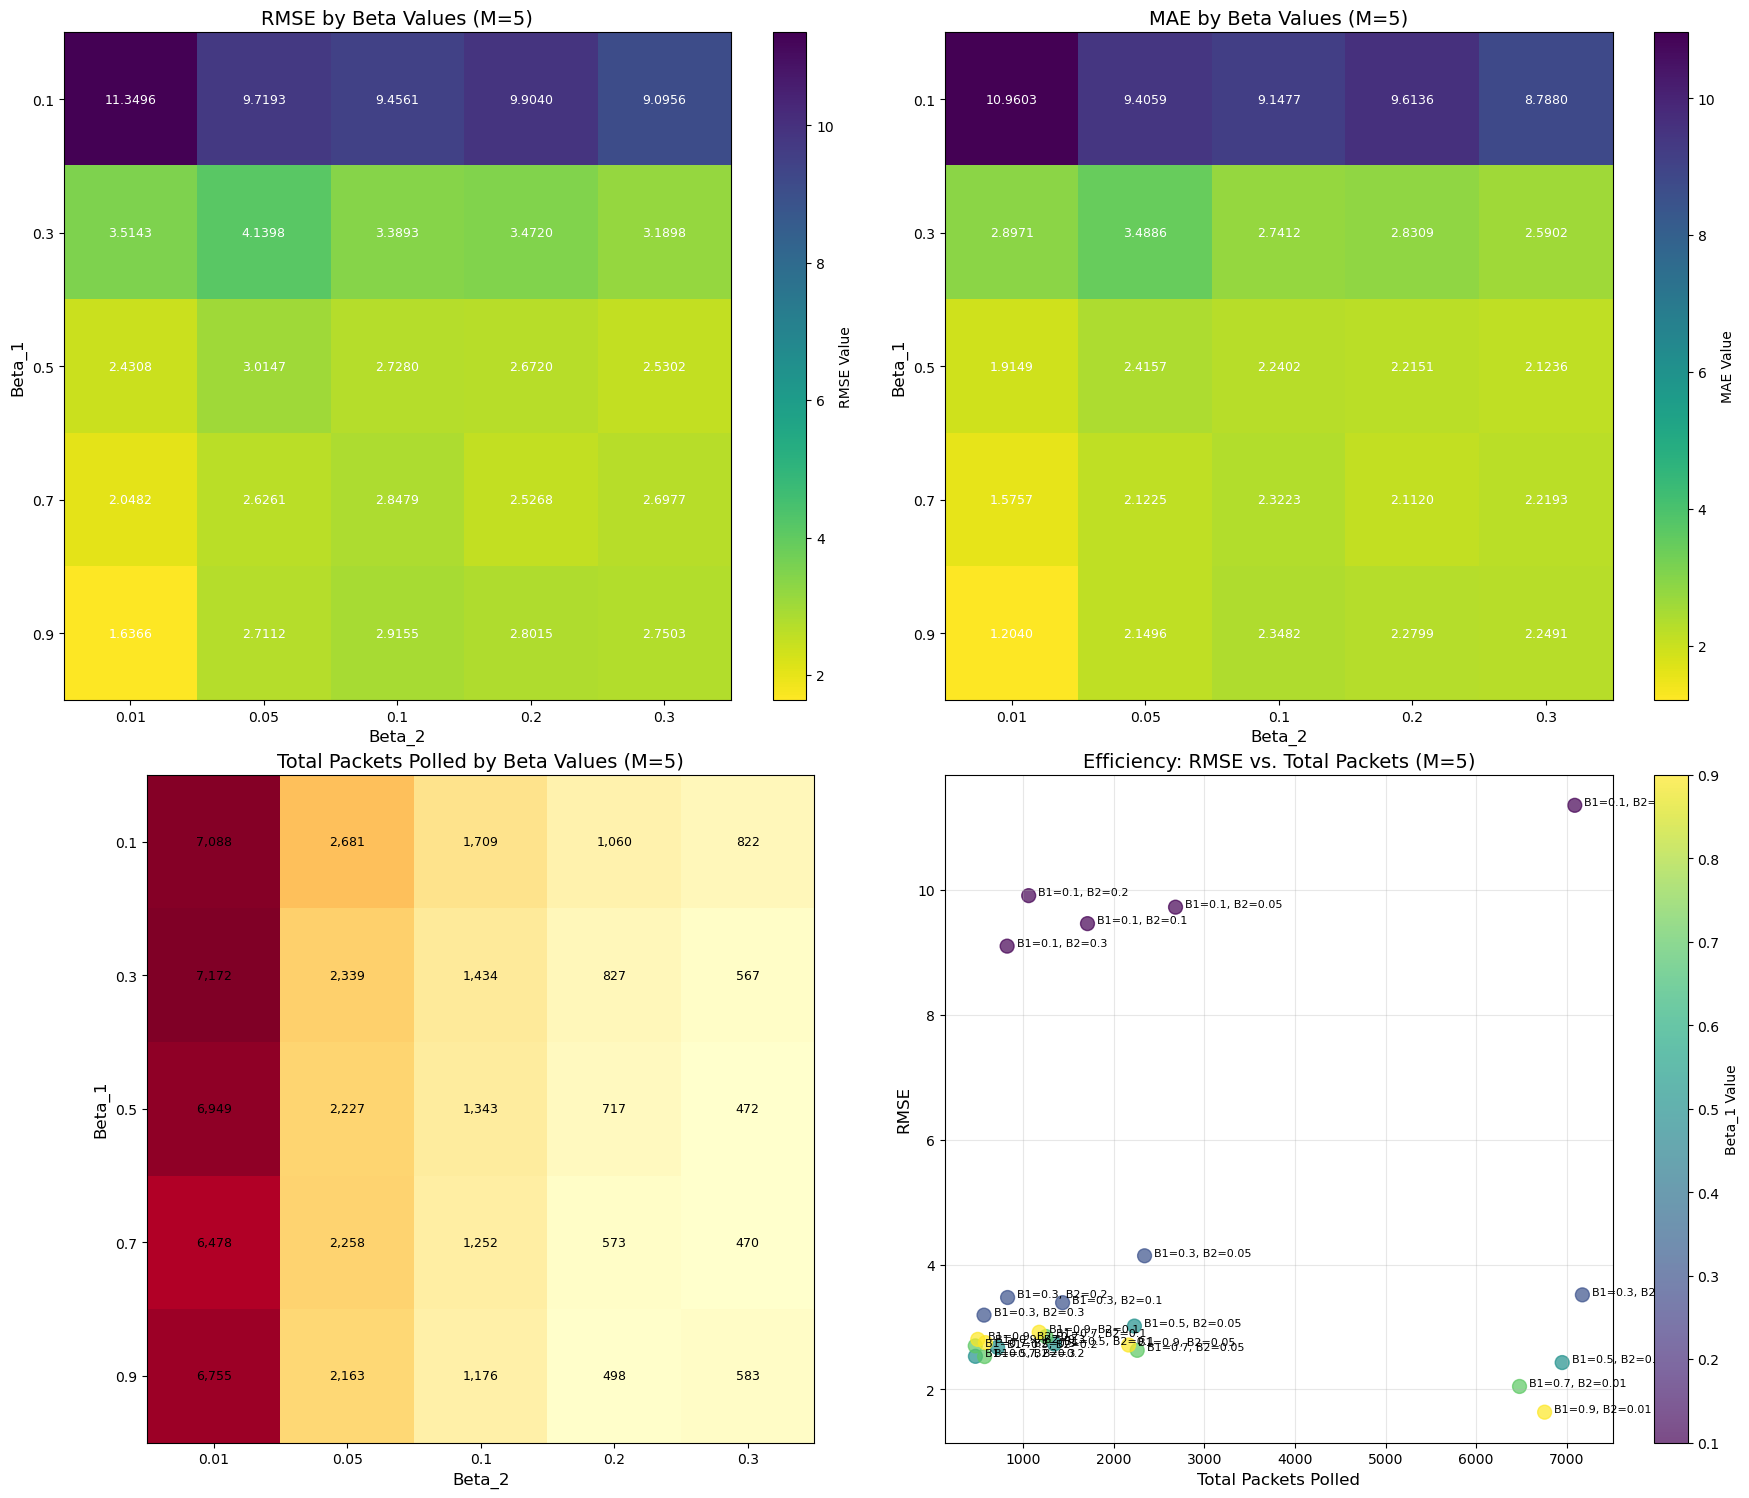

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
#pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 10000 time steps

# Fixed parameters
reward = 0.5
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values
M = 5  # Fixed value for maximum number of nodes to poll

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Create a mapping of columns to categories
column_categories = {}
for col in columns:
    node_id = ''.join(filter(str.isdigit, col))
    if node_id:
        node_id = int(node_id)
        if 1 <= node_id <= 10:
            column_categories[col] = 'Category A'
        elif 11 <= node_id <= 20:
            column_categories[col] = 'Category B'
        elif 21 <= node_id <= 30:
            column_categories[col] = 'Category C'
    else:
        column_categories[col] = 'Uncategorized'

# Group columns by category
category_columns = {
    'Category A': [col for col, cat in column_categories.items() if cat == 'Category A'],
    'Category B': [col for col, cat in column_categories.items() if cat == 'Category B'],
    'Category C': [col for col, cat in column_categories.items() if cat == 'Category C'],
    'Uncategorized': [col for col, cat in column_categories.items() if cat == 'Uncategorized']
}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Dynamic Penalty Update algorithm based on Whittle indices
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Convert dictionary values to a list of whittle indices, handling any NaN values
    c_values = []
    for v in whittle_indices.values():
        if np.isnan(v):
            c_values.append(-float('inf'))  # Treat NaN as negative infinity (won't be polled)
        else:
            c_values.append(v)
    
    # Identify the set ℰ of nodes where c_i > λ(t)
    eligible_nodes = [i for i, c_i in enumerate(c_values) if c_i > current_lambda]
    
    # If |ℰ| ≤ M, no penalty update needed
    if len(eligible_nodes) <= M:
        return current_lambda
    
    # Sort the c_i values in descending order
    sorted_c_values = sorted(c_values, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_c_values[M-1]
    
    # Update penalty to the M-th value
    new_lambda = M_th_value
    
    return new_lambda

# Main function to simulate Whittle AoII with rewards and track transmission counts
def run_simulation_whittle_aoii_dynamic_penalty(pivot_df, columns, M, beta_1, beta_2):
    # Track the number of times each category is pulled
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0, 'Uncategorized': 0}
    total_polls = 0  # Track total number of polls across all nodes
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero
    
    # Track estimated values and MSE
    estimated_values = {col: np.zeros(len(pivot_df)) for col in columns}
    
    # Track errors separately for each category
    category_errors = {
        cat: {'squared_errors': [], 'absolute_errors': []} 
        for cat in ['Category A', 'Category B', 'Category C', 'Uncategorized', 'Overall']
    }
    
    # Initialize estimated values with initial state
    for col in columns:
        estimated_values[col][0] = state_node[col][0]

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations - with safety checks for NaN/Inf values
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            
            # Calculate the Whittle index with safeguards against invalid values
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Update the dynamic penalty (λ) using the algorithm
        aoii_penalty = dynamic_penalty_update(whittle_indices, M, aoii_penalty)
        penalty_values.append(aoii_penalty)
        
        # Step 3: Select nodes to poll based on the updated penalty
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= aoii_penalty]
        nodes_polled_count.append(len(nodes_to_poll))
        total_polls += len(nodes_to_poll)  # Update total polls count

        # Step 4: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update (ensure at least 1)

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Count polling by category
            cat = column_categories.get(col, 'Uncategorized')
            category_counts[cat] += 1
        
        # Step 5: Update estimated values for all nodes (polled and non-polled)
        for col in columns:
            if col in nodes_to_poll:
                # For polled nodes, use the actual measurement
                estimated_values[col][t] = float(pivot_df.loc[t, col])
            else:
                # For non-polled nodes, use the predicted value from the state model
                last_state_value, last_rate_of_change = state_node[col]
                delta_t_since_last = max(min_delta_t, t - last_update_times[col])
                # Predict using the linear model: x(t) = x(t-1) + rate * delta_t
                estimated_values[col][t] = last_state_value + last_rate_of_change * delta_t_since_last
        
        # Calculate errors for each category
        for category, cat_columns in category_columns.items():
            if cat_columns:  # Skip empty categories
                # Get true and estimated values for this category
                true_cat_values = np.array([pivot_df.loc[t, col] for col in cat_columns])
                est_cat_values = np.array([estimated_values[col][t] for col in cat_columns])
                
                # Calculate squared errors and absolute errors
                squared_errors = (true_cat_values - est_cat_values) ** 2
                absolute_errors = np.abs(true_cat_values - est_cat_values)
                
                # Store errors
                category_errors[category]['squared_errors'].extend(squared_errors)
                category_errors[category]['absolute_errors'].extend(absolute_errors)
        
        # Calculate overall errors (across all columns)
        true_values = np.array([pivot_df.loc[t, col] for col in columns])
        est_values = np.array([estimated_values[col][t] for col in columns])
        
        squared_errors = (true_values - est_values) ** 2
        absolute_errors = np.abs(true_values - est_values)
        
        category_errors['Overall']['squared_errors'].extend(squared_errors)
        category_errors['Overall']['absolute_errors'].extend(absolute_errors)

    # Calculate final error metrics for each category
    error_metrics = {}
    for category, errors in category_errors.items():
        if errors['squared_errors']:  # Skip empty categories
            # Calculate MSE, RMSE, and MAE
            mse = np.mean(errors['squared_errors'])
            rmse = np.sqrt(mse)
            mae = np.mean(errors['absolute_errors'])
            
            error_metrics[category] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae
            }

    return {
        'total_polls': total_polls,
        'category_counts': category_counts,
        'error_metrics': error_metrics
    }

# Beta values to test
beta1_values = [0.1, 0.3, 0.5, 0.7, 0.9]
beta2_values = [0.01, 0.05, 0.1, 0.2, 0.3]

# Store results in a dictionary
results = {}

# Print header
print("Running simulations for different Beta values with M =", M)
print("-" * 80)
print(f"{'Beta_1':<10}{'Beta_2':<10}{'Status':<20}")
print("-" * 80)

# Run simulations for all combinations of Beta_1 and Beta_2
for beta_1 in beta1_values:
    for beta_2 in beta2_values:
        beta_key = (beta_1, beta_2)
        print(f"{beta_1:<10.2f}{beta_2:<10.2f}{'Running...':<20}", end='', flush=True)
        
        result = run_simulation_whittle_aoii_dynamic_penalty(
            pivot_df, columns, M, beta_1, beta_2
        )
        
        results[beta_key] = result
        print(f"Completed")

print("-" * 80)

# Print detailed results showing RMSE and MAE for each combination
print("\nDetailed Error Metrics by Beta Values (M =", M, "):")
print("-" * 110)
header = f"{'Beta_1':<10}{'Beta_2':<10}{'Category':<15}{'RMSE':<15}{'MAE':<15}{'Polls':<15}"
print(header)
print("-" * 110)

# Collect data for plotting
plot_data = []

# Print results for each combination
for beta_1 in beta1_values:
    for beta_2 in beta2_values:
        beta_key = (beta_1, beta_2)
        result = results[beta_key]
        metrics = result['error_metrics']
        
        # Print overall metrics
        overall = metrics.get('Overall', {'RMSE': 0, 'MAE': 0})
        total_polls = result['total_polls']
        print(f"{beta_1:<10.2f}{beta_2:<10.2f}{'Overall':<15}{overall['RMSE']:<15.6f}{overall['MAE']:<15.6f}{total_polls:<15,d}")
        
        # Collect data for plotting
        plot_data.append({
            'Beta_1': beta_1,
            'Beta_2': beta_2,
            'RMSE': overall['RMSE'],
            'MAE': overall['MAE'],
            'Total_Polls': total_polls
        })
        
        # Print category-specific metrics
        for category in ['Category A', 'Category B', 'Category C']:
            if category in metrics:
                cat_metrics = metrics[category]
                cat_polls = result['category_counts'].get(category, 0)
                print(f"{'':<10}{'':<10}{category:<15}{cat_metrics['RMSE']:<15.6f}{cat_metrics['MAE']:<15.6f}{cat_polls:<15,d}")
        
        # Add a separator between different beta combinations
        print("-" * 110)

# Create a dataframe with all results and save to CSV
results_data = []
for beta_1 in beta1_values:
    for beta_2 in beta2_values:
        beta_key = (beta_1, beta_2)
        result = results[beta_key]
        metrics = result['error_metrics']
        
        # Overall metrics
        overall = metrics.get('Overall', {'RMSE': 0, 'MAE': 0})
        row = {
            'Beta_1': beta_1,
            'Beta_2': beta_2,
            'Category': 'Overall',
            'RMSE': overall['RMSE'],
            'MAE': overall['MAE'],
            'Polls': result['total_polls']
        }
        results_data.append(row)
        
        # Category-specific metrics
        for category in ['Category A', 'Category B', 'Category C']:
            if category in metrics:
                cat_metrics = metrics[category]
                cat_polls = result['category_counts'].get(category, 0)
                row = {
                    'Beta_1': beta_1,
                    'Beta_2': beta_2,
                    'Category': category,
                    'RMSE': cat_metrics['RMSE'],
                    'MAE': cat_metrics['MAE'],
                    'Polls': cat_polls
                }
                results_data.append(row)

results_df = pd.DataFrame(results_data)
results_df.to_csv("beta_comparison_results.csv", index=False)
print("\nResults saved to 'beta_comparison_results.csv'")

# Create plots for RMSE, MAE, and Total Polls
plot_df = pd.DataFrame(plot_data)

# Plot setup
fig = plt.figure(figsize=(18, 15))

# Plot 1: RMSE heatmap
ax1 = fig.add_subplot(2, 2, 1)
pivot_rmse = plot_df.pivot(index='Beta_1', columns='Beta_2', values='RMSE')
im1 = ax1.imshow(pivot_rmse, cmap='viridis_r')  # Reverse colormap so darker is better (lower RMSE)
ax1.set_title('RMSE by Beta Values (M=5)', fontsize=14)
ax1.set_xlabel('Beta_2', fontsize=12)
ax1.set_ylabel('Beta_1', fontsize=12)
ax1.set_xticks(np.arange(len(beta2_values)))
ax1.set_yticks(np.arange(len(beta1_values)))
ax1.set_xticklabels(beta2_values)
ax1.set_yticklabels(beta1_values)

# Add RMSE values to heatmap cells
for i in range(len(beta1_values)):
    for j in range(len(beta2_values)):
        text = ax1.text(j, i, f"{pivot_rmse.iloc[i, j]:.4f}", 
                       ha="center", va="center", color="w", fontsize=9)

plt.colorbar(im1, ax=ax1, label='RMSE Value')

# Plot 2: MAE heatmap
ax2 = fig.add_subplot(2, 2, 2)
pivot_mae = plot_df.pivot(index='Beta_1', columns='Beta_2', values='MAE')
im2 = ax2.imshow(pivot_mae, cmap='viridis_r')  # Reverse colormap so darker is better (lower MAE)
ax2.set_title('MAE by Beta Values (M=5)', fontsize=14)
ax2.set_xlabel('Beta_2', fontsize=12)
ax2.set_ylabel('Beta_1', fontsize=12)
ax2.set_xticks(np.arange(len(beta2_values)))
ax2.set_yticks(np.arange(len(beta1_values)))
ax2.set_xticklabels(beta2_values)
ax2.set_yticklabels(beta1_values)

# Add MAE values to heatmap cells
for i in range(len(beta1_values)):
    for j in range(len(beta2_values)):
        text = ax2.text(j, i, f"{pivot_mae.iloc[i, j]:.4f}", 
                       ha="center", va="center", color="w", fontsize=9)

plt.colorbar(im2, ax=ax2, label='MAE Value')

# Plot 3: Total Polls heatmap
ax3 = fig.add_subplot(2, 2, 3)
pivot_polls = plot_df.pivot(index='Beta_1', columns='Beta_2', values='Total_Polls')
im3 = ax3.imshow(pivot_polls, cmap='YlOrRd')  # Yellow-Orange-Red colormap
ax3.set_title('Total Packets Polled by Beta Values (M=5)', fontsize=14)
ax3.set_xlabel('Beta_2', fontsize=12)
ax3.set_ylabel('Beta_1', fontsize=12)
ax3.set_xticks(np.arange(len(beta2_values)))
ax3.set_yticks(np.arange(len(beta1_values)))
ax3.set_xticklabels(beta2_values)
ax3.set_yticklabels(beta1_values)

# Add poll values to heatmap cells
for i in range(len(beta1_values)):
    for j in range(len(beta2_values)):
        text = ax3.text(j, i, f"{int(pivot_polls.iloc[i, j]):,}", 
                       ha="center", va="center", color="black", fontsize=9)

# Plot 4: Efficiency plot (RMSE vs. Total Polls)
ax4 = fig.add_subplot(2, 2, 4)
scatter = ax4.scatter(plot_df['Total_Polls'], plot_df['RMSE'], 
                     c=plot_df['Beta_1'], cmap='viridis', s=100, alpha=0.7)
ax4.set_title('Efficiency: RMSE vs. Total Packets (M=5)', fontsize=14)
ax4.set_xlabel('Total Packets Polled', fontsize=12)
ax4.set_ylabel('RMSE', fontsize=12)
ax4.grid(True, alpha=0.3)

# Add labels for each point
for i, row in plot_df.iterrows():
    ax4.annotate(f"B1={row['Beta_1']}, B2={row['Beta_2']}", 
                (row['Total_Polls'], row['RMSE']),
                xytext=(7, 0), textcoords='offset points', fontsize=8)

plt.colorbar(scatter, ax=ax4, label='Beta_1 Value')

plt.tight_layout()
plt.savefig('beta_comparison_plots.png', dpi=300)
plt.show()

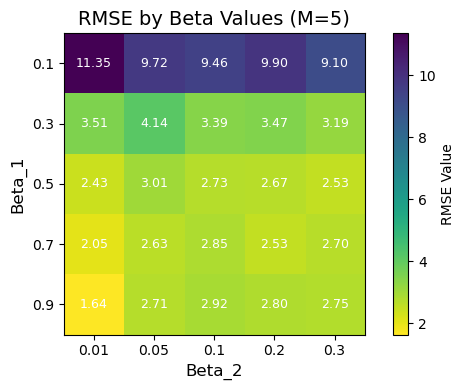

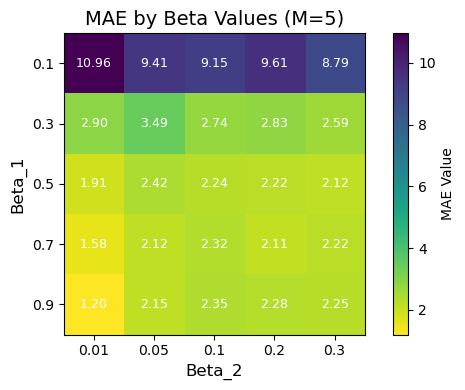

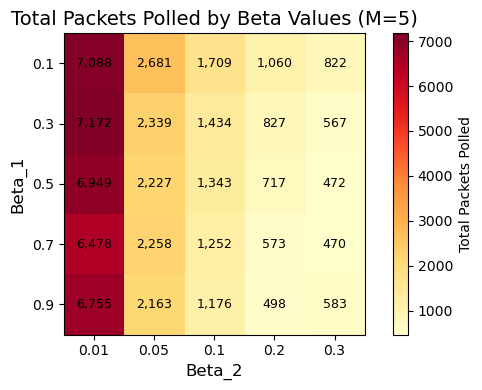

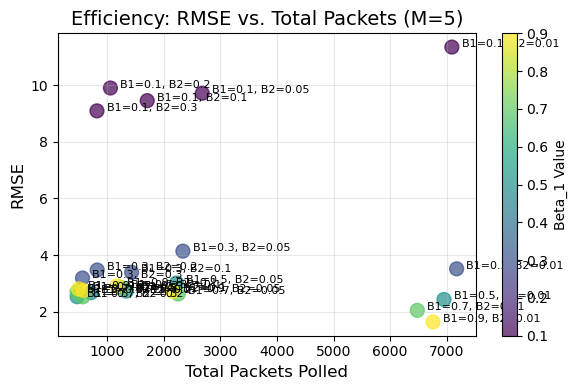

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming plot_df, beta1_values, and beta2_values are already defined

# Plot 1: RMSE heatmap (separate figure)
plt.figure(figsize=(6, 4))
pivot_rmse = plot_df.pivot(index='Beta_1', columns='Beta_2', values='RMSE')
im1 = plt.imshow(pivot_rmse, cmap='viridis_r')  # Reverse colormap so darker is better (lower RMSE)
plt.title('RMSE by Beta Values (M=5)', fontsize=14)
plt.xlabel('Beta_2', fontsize=12)
plt.ylabel('Beta_1', fontsize=12)
plt.xticks(np.arange(len(beta2_values)), beta2_values)
plt.yticks(np.arange(len(beta1_values)), beta1_values)

# Add RMSE values to heatmap cells
for i in range(len(beta1_values)):
    for j in range(len(beta2_values)):
        plt.text(j, i, f"{pivot_rmse.iloc[i, j]:.2f}", 
                ha="center", va="center", color="w", fontsize=9)

plt.colorbar(im1, label='RMSE Value')
plt.tight_layout()
plt.savefig('rmse_heatmap.png', dpi=300)
plt.show()

# Plot 2: MAE heatmap (separate figure)
plt.figure(figsize=(6, 4))
pivot_mae = plot_df.pivot(index='Beta_1', columns='Beta_2', values='MAE')
im2 = plt.imshow(pivot_mae, cmap='viridis_r')  # Reverse colormap so darker is better (lower MAE)
plt.title('MAE by Beta Values (M=5)', fontsize=14)
plt.xlabel('Beta_2', fontsize=12)
plt.ylabel('Beta_1', fontsize=12)
plt.xticks(np.arange(len(beta2_values)), beta2_values)
plt.yticks(np.arange(len(beta1_values)), beta1_values)

# Add MAE values to heatmap cells
for i in range(len(beta1_values)):
    for j in range(len(beta2_values)):
        plt.text(j, i, f"{pivot_mae.iloc[i, j]:.2f}", 
                ha="center", va="center", color="w", fontsize=9)

plt.colorbar(im2, label='MAE Value')
plt.tight_layout()
plt.savefig('mae_heatmap.png', dpi=300)
plt.show()

# Plot 3: Total Polls heatmap (separate figure)
plt.figure(figsize=(6, 4))
pivot_polls = plot_df.pivot(index='Beta_1', columns='Beta_2', values='Total_Polls')
im3 = plt.imshow(pivot_polls, cmap='YlOrRd')  # Yellow-Orange-Red colormap
plt.title('Total Packets Polled by Beta Values (M=5)', fontsize=14)
plt.xlabel('Beta_2', fontsize=12)
plt.ylabel('Beta_1', fontsize=12)
plt.xticks(np.arange(len(beta2_values)), beta2_values)
plt.yticks(np.arange(len(beta1_values)), beta1_values)

# Add poll values to heatmap cells
for i in range(len(beta1_values)):
    for j in range(len(beta2_values)):
        plt.text(j, i, f"{int(pivot_polls.iloc[i, j]):,}", 
                ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im3, label='Total Packets Polled')
plt.tight_layout()
plt.savefig('total_polls_heatmap.png', dpi=300)
plt.show()

# Plot 4: Efficiency plot (RMSE vs. Total Polls) (separate figure)
plt.figure(figsize=(6, 4))
scatter = plt.scatter(plot_df['Total_Polls'], plot_df['RMSE'], 
                     c=plot_df['Beta_1'], cmap='viridis', s=100, alpha=0.7)
plt.title('Efficiency: RMSE vs. Total Packets (M=5)', fontsize=14)
plt.xlabel('Total Packets Polled', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True, alpha=0.3)

# Add labels for each point
for i, row in plot_df.iterrows():
    plt.annotate(f"B1={row['Beta_1']}, B2={row['Beta_2']}", 
                (row['Total_Polls'], row['RMSE']),
                xytext=(7, 0), textcoords='offset points', fontsize=8)

plt.colorbar(scatter, label='Beta_1 Value')
plt.tight_layout()
plt.savefig('efficiency_plot.png', dpi=300)
plt.show()

# Fairness index 

In [49]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 10000 time steps

# Fixed parameters
reward = 0.5
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values
M = 1  # Fixed value for maximum number of nodes to poll
beta_1 = 0.98 # Fixed dEWMA parameter for state value
beta_2 = 0.0001  # Fixed dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Create a mapping of columns to categories
column_categories = {}
for col in columns:
    node_id = ''.join(filter(str.isdigit, col))
    if node_id:
        node_id = int(node_id)
        if 1 <= node_id <= 10:
            column_categories[col] = 'Category A'
        elif 11 <= node_id <= 20:
            column_categories[col] = 'Category B'
        elif 21 <= node_id <= 30:
            column_categories[col] = 'Category C'
    else:
        column_categories[col] = 'Uncategorized'

# Group columns by category
category_columns = {
    'Category A': [col for col, cat in column_categories.items() if cat == 'Category A'],
    'Category B': [col for col, cat in column_categories.items() if cat == 'Category B'],
    'Category C': [col for col, cat in column_categories.items() if cat == 'Category C'],
    'Uncategorized': [col for col, cat in column_categories.items() if cat == 'Uncategorized']
}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Dynamic Penalty Update algorithm based on Whittle indices
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Convert dictionary values to a list of whittle indices, handling any NaN values
    c_values = []
    for v in whittle_indices.values():
        if np.isnan(v):
            c_values.append(-float('inf'))  # Treat NaN as negative infinity (won't be polled)
        else:
            c_values.append(v)
    
    # Identify the set ℰ of nodes where c_i > λ(t)
    eligible_nodes = [i for i, c_i in enumerate(c_values) if c_i > current_lambda]
    
    # If |ℰ| ≤ M, no penalty update needed
    if len(eligible_nodes) <= M:
        return current_lambda
    
    # Sort the c_i values in descending order
    sorted_c_values = sorted(c_values, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_c_values[M-1]
    
    # Update penalty to the M-th value
    new_lambda = M_th_value
    
    return new_lambda

# Main function to simulate Whittle AoII with rewards, fairness and track transmission counts
def run_simulation_with_fairness(pivot_df, columns, M, L):
    # Track the number of times each category is pulled
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0, 'Uncategorized': 0}
    total_polls = 0  # Track total number of polls across all nodes
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.0
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero
    
    # Track estimated values and MSE
    estimated_values = {col: np.zeros(len(pivot_df)) for col in columns}
    
    # Fairness tracking
    fairness_activations = []  # Track timesteps where fairness is activated
    forced_polls_count = 0  # Track how many times the fairness constraint is activated
    
    # Track errors separately for each category
    category_errors = {
        cat: {'squared_errors': [], 'absolute_errors': []} 
        for cat in ['Category A', 'Category B', 'Category C', 'Uncategorized', 'Overall']
    }
    
    # Initialize estimated values with initial state
    for col in columns:
        estimated_values[col][0] = state_node[col][0]

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations - with safety checks for NaN/Inf values
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            
            # Calculate the Whittle index with safeguards against invalid values
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Update the dynamic penalty (λ) using the algorithm
        aoii_penalty = dynamic_penalty_update(whittle_indices, M, aoii_penalty)
        penalty_values.append(aoii_penalty)
        
        # Step 3: Select nodes to poll based on the updated penalty
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= aoii_penalty]
        
        # Step 4: Identify nodes that haven't been polled for L time steps
        starved_nodes = []
        for col in columns:
            if t - last_update_times[col] >= L and col not in nodes_to_poll:
                starved_nodes.append(col)
        
        # Step 5: Apply fairness constraint - replace least valuable nodes with starved nodes
        fairness_applied = False
        if starved_nodes:
            fairness_activations.append(t)
            fairness_applied = True
            
            # Sort nodes_to_poll by their Whittle indices (ascending order - lowest first)
            nodes_to_poll_sorted = sorted(nodes_to_poll, key=lambda x: whittle_indices.get(x, -float('inf')))
            
            # Replace the nodes with lowest Whittle indices with starved nodes
            for starved_node in starved_nodes:
                if nodes_to_poll_sorted:
                    # Record that fairness was applied
                    forced_polls_count += 1
                    
                    # Replace a node
                    replaced_node = nodes_to_poll_sorted.pop(0)  # Remove the node with lowest index
                    nodes_to_poll.remove(replaced_node)  # Remove from original list
                    nodes_to_poll.append(starved_node)  # Add the starved node
                else:
                    break  # No more nodes to replace
        
        nodes_polled_count.append(len(nodes_to_poll))
        total_polls += len(nodes_to_poll)  # Update total polls count

        # Step 6: Poll selected nodes and update states
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update (ensure at least 1)

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Count polling by category
            cat = column_categories.get(col, 'Uncategorized')
            category_counts[cat] += 1
        
        # Step 7: Update estimated values for all nodes (polled and non-polled)
        for col in columns:
            if col in nodes_to_poll:
                # For polled nodes, use the actual measurement
                estimated_values[col][t] = float(pivot_df.loc[t, col])
            else:
                # For non-polled nodes, use the predicted value from the state model
                last_state_value, last_rate_of_change = state_node[col]
                delta_t_since_last = max(min_delta_t, t - last_update_times[col])
                # Predict using the linear model: x(t) = x(t-1) + rate * delta_t
                estimated_values[col][t] = last_state_value + last_rate_of_change * delta_t_since_last
        
        # Calculate errors for each category
        for category, cat_columns in category_columns.items():
            if cat_columns:  # Skip empty categories
                # Get true and estimated values for this category
                true_cat_values = np.array([pivot_df.loc[t, col] for col in cat_columns])
                est_cat_values = np.array([estimated_values[col][t] for col in cat_columns])
                
                # Calculate squared errors and absolute errors
                squared_errors = (true_cat_values - est_cat_values) ** 2
                absolute_errors = np.abs(true_cat_values - est_cat_values)
                
                # Store errors
                category_errors[category]['squared_errors'].extend(squared_errors)
                category_errors[category]['absolute_errors'].extend(absolute_errors)
        
        # Calculate overall errors (across all columns)
        true_values = np.array([pivot_df.loc[t, col] for col in columns])
        est_values = np.array([estimated_values[col][t] for col in columns])
        
        squared_errors = (true_values - est_values) ** 2
        absolute_errors = np.abs(true_values - est_values)
        
        category_errors['Overall']['squared_errors'].extend(squared_errors)
        category_errors['Overall']['absolute_errors'].extend(absolute_errors)

    # Calculate final error metrics for each category
    error_metrics = {}
    for category, errors in category_errors.items():
        if errors['squared_errors']:  # Skip empty categories
            # Calculate MSE, RMSE, and MAE
            mse = np.mean(errors['squared_errors'])
            rmse = np.sqrt(mse)
            mae = np.mean(errors['absolute_errors'])
            
            error_metrics[category] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae
            }

    # Fairness metrics
    fairness_metrics = {
        'fairness_activations': len(fairness_activations),
        'forced_polls_count': forced_polls_count
    }

    return {
        'total_polls': total_polls,
        'category_counts': category_counts,
        'error_metrics': error_metrics,
        'fairness_metrics': fairness_metrics
    }

# Fairness threshold values to test
L_values = [100, 200, 500, 1000, 2000]

# Store results in a dictionary
results = {}

# Print header
print("Running simulations for different Fairness Threshold (L) values with M =", M)
print("-" * 80)
print(f"{'L':<10}{'Status':<20}")
print("-" * 80)

# Run simulations for all L values
for L in L_values:
    print(f"{L:<10}{'Running...':<20}", end='', flush=True)
    
    result = run_simulation_with_fairness(
        pivot_df, columns, M, L
    )
    
    results[L] = result
    print(f"Completed")

print("-" * 80)

# Print detailed results showing MSE, RMSE and MAE for each L value
print("\nDetailed Error Metrics by Fairness Threshold (L) Values (M =", M, "):")
print("-" * 110)
header = f"{'L':<10}{'Category':<15}{'MSE':<15}{'RMSE':<15}{'MAE':<15}{'Polls':<15}{'Fairness Acts':<15}"
print(header)
print("-" * 110)

# Print results for each L value
for L in L_values:
    result = results[L]
    metrics = result['error_metrics']
    fairness = result['fairness_metrics']
    
    # Print overall metrics
    overall = metrics.get('Overall', {'MSE': 0, 'RMSE': 0, 'MAE': 0})
    total_polls = result['total_polls']
    fairness_acts = fairness['fairness_activations']
    print(f"{L:<10}{'Overall':<15}{overall['MSE']:<15.6f}{overall['RMSE']:<15.6f}{overall['MAE']:<15.6f}{total_polls:<15,d}{fairness_acts:<15,d}")
    
    # Print category-specific metrics
    for category in ['Category A', 'Category B', 'Category C']:
        if category in metrics:
            cat_metrics = metrics[category]
            cat_polls = result['category_counts'].get(category, 0)
            print(f"{'':<10}{category:<15}{cat_metrics['MSE']:<15.6f}{cat_metrics['RMSE']:<15.6f}{cat_metrics['MAE']:<15.6f}{cat_polls:<15,d}{'':<15}")
    
    # Add a separator between different L values
    print("-" * 110)

# Create a dataframe with all results and save to CSV
results_data = []
for L in L_values:
    result = results[L]
    metrics = result['error_metrics']
    fairness = result['fairness_metrics']
    
    # Overall metrics
    overall = metrics.get('Overall', {'MSE': 0, 'RMSE': 0, 'MAE': 0})
    row = {
        'L': L,
        'Category': 'Overall',
        'MSE': overall['MSE'],
        'RMSE': overall['RMSE'],
        'MAE': overall['MAE'],
        'Polls': result['total_polls'],
        'Fairness_Activations': fairness['fairness_activations'],
        'Forced_Polls': fairness['forced_polls_count']
    }
    results_data.append(row)
    
    # Category-specific metrics
    for category in ['Category A', 'Category B', 'Category C']:
        if category in metrics:
            cat_metrics = metrics[category]
            cat_polls = result['category_counts'].get(category, 0)
            row = {
                'L': L,
                'Category': category,
                'MSE': cat_metrics['MSE'],
                'RMSE': cat_metrics['RMSE'],
                'MAE': cat_metrics['MAE'],
                'Polls': cat_polls
            }
            results_data.append(row)

results_df = pd.DataFrame(results_data)
results_df.to_csv("fairness_threshold_comparison.csv", index=False)
print("\nResults saved to 'fairness_threshold_comparison.csv'")

Running simulations for different Fairness Threshold (L) values with M = 1
--------------------------------------------------------------------------------
L         Status              
--------------------------------------------------------------------------------
100       Running...          Completed
200       Running...          Completed
500       Running...          Completed
1000      Running...          Completed
2000      Running...          Completed
--------------------------------------------------------------------------------

Detailed Error Metrics by Fairness Threshold (L) Values (M = 1 ):
--------------------------------------------------------------------------------------------------------------
L         Category       MSE            RMSE           MAE            Polls          Fairness Acts  
--------------------------------------------------------------------------------------------------------------
100       Overall        1355.309640    36.814530      29.116

In [47]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes_2.csv")
pivot_df = pd.read_csv("simulated_office_environment.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 10000 time steps

# Fixed parameters
reward = 0.5
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
initial_value = 20  # Initial estimate for last polled values
M = 1 # Fixed value for maximum number of nodes to poll
beta_1 = 0.9 # Fixed dEWMA parameter for state value
beta_2 = 0.01  # Fixed dEWMA parameter for rate of change

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]
num_nodes = len(columns)  # Number of sensor nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length

# Create a mapping of columns to categories
column_categories = {}
for col in columns:
    node_id = ''.join(filter(str.isdigit, col))
    if node_id:
        node_id = int(node_id)
        if 1 <= node_id <= 10:
            column_categories[col] = 'Category A'
        elif 11 <= node_id <= 20:
            column_categories[col] = 'Category B'
        elif 21 <= node_id <= 30:
            column_categories[col] = 'Category C'
    else:
        column_categories[col] = 'Uncategorized'

# Group columns by category
category_columns = {
    'Category A': [col for col, cat in column_categories.items() if cat == 'Category A'],
    'Category B': [col for col, cat in column_categories.items() if cat == 'Category B'],
    'Category C': [col for col, cat in column_categories.items() if cat == 'Category C'],
    'Uncategorized': [col for col, cat in column_categories.items() if cat == 'Uncategorized']
}

# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    # Handle potential NaN or Inf values
    time_diff = current_time - last_received_time
    if np.isnan(last_rate_of_change) or np.isinf(last_rate_of_change):
        return 0.0  # Default to zero if rate of change is invalid
    return abs(time_diff * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    # Handle the case where delta_t is 0 to avoid division by zero
    if delta_t == 0:
        return measured_value, last_rate_of_change  # Return measured value and keep the last rate of change
    
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Dynamic Penalty Update algorithm based on Whittle indices
def dynamic_penalty_update(whittle_indices, M, current_lambda):
    # Convert dictionary values to a list of whittle indices, handling any NaN values
    c_values = []
    for v in whittle_indices.values():
        if np.isnan(v):
            c_values.append(-float('inf'))  # Treat NaN as negative infinity (won't be polled)
        else:
            c_values.append(v)
    
    # Identify the set ℰ of nodes where c_i > λ(t)
    eligible_nodes = [i for i, c_i in enumerate(c_values) if c_i > current_lambda]
    
    # If |ℰ| ≤ M, no penalty update needed
    if len(eligible_nodes) <= M:
        return current_lambda
    
    # Sort the c_i values in descending order
    sorted_c_values = sorted(c_values, reverse=True)
    
    # Identify the M-th value
    M_th_value = sorted_c_values[M-1]
    
    # Update penalty to the M-th value
    new_lambda = M_th_value
    
    return new_lambda

# Main function to simulate Whittle AoII with rewards, fairness and track transmission counts
def run_simulation_with_fairness(pivot_df, columns, M, theta, penalty, L):
    # Track the number of times each category is pulled
    category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0, 'Uncategorized': 0}
    total_polls = 0  # Track total number of polls across all nodes
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states
    
    # Initialize dynamic penalty (λ) to 0
    aoii_penalty = 0.5
    
    # Track penalty evolution
    penalty_values = [aoii_penalty]
    
    # Track nodes polled at each time step
    nodes_polled_count = []
    
    # Set minimum timestamp difference to avoid division by zero
    min_delta_t = 1  # Minimum time difference of 1 to avoid division by zero
    
    # Track estimated values and MSE
    estimated_values = {col: np.zeros(len(pivot_df)) for col in columns}
    
    # Fairness tracking
    fairness_activations = []  # Track timesteps where fairness is activated
    forced_polls_count = 0  # Track how many times the fairness constraint is activated
    
    # Track errors separately for each category
    category_errors = {
        cat: {'squared_errors': [], 'absolute_errors': []} 
        for cat in ['Category A', 'Category B', 'Category C', 'Uncategorized', 'Overall']
    }
    
    # Initialize estimated values with initial state
    for col in columns:
        estimated_values[col][0] = state_node[col][0]

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations - with safety checks for NaN/Inf values
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            
            # Calculate the Whittle index with safeguards against invalid values
            whittle_index = q_passive - q_active
            
            # Handle NaN or Inf values
            if np.isnan(whittle_index) or np.isinf(whittle_index):
                whittle_indices[col] = -float('inf')  # Set to negative infinity if invalid
            else:
                whittle_indices[col] = whittle_index

        # Step 2: Update the dynamic penalty (λ) using the algorithm
        aoii_penalty = dynamic_penalty_update(whittle_indices, M, aoii_penalty)
        penalty_values.append(aoii_penalty)
        
        # Step 3: Select nodes to poll based on the updated penalty
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= aoii_penalty]
        
        # Step 4: Identify nodes that haven't been polled for L time steps
        starved_nodes = []
        for col in columns:
            if t - last_update_times[col] >= L and col not in nodes_to_poll:
                starved_nodes.append(col)
        
        # Step 5: Apply fairness constraint - replace least valuable nodes with starved nodes
        fairness_applied = False
        if starved_nodes:
            fairness_activations.append(t)
            fairness_applied = True
            
            # Sort nodes_to_poll by their Whittle indices (ascending order - lowest first)
            nodes_to_poll_sorted = sorted(nodes_to_poll, key=lambda x: whittle_indices.get(x, -float('inf')))
            
            # Replace the nodes with lowest Whittle indices with starved nodes
            for starved_node in starved_nodes:
                if nodes_to_poll_sorted:
                    # Record that fairness was applied
                    forced_polls_count += 1
                    
                    # Replace a node
                    replaced_node = nodes_to_poll_sorted.pop(0)  # Remove the node with lowest index
                    nodes_to_poll.remove(replaced_node)  # Remove from original list
                    nodes_to_poll.append(starved_node)  # Add the starved node
                else:
                    break  # No more nodes to replace
        
        nodes_polled_count.append(len(nodes_to_poll))
        total_polls += len(nodes_to_poll)  # Update total polls count

        # Step 6: Poll selected nodes and update states
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            delta_t_dynamic = max(min_delta_t, t - last_update_times[col])  # Time since last update (ensure at least 1)

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

            # Count polling by category
            cat = column_categories.get(col, 'Uncategorized')
            category_counts[cat] += 1
        
        # Step 7: Update estimated values for all nodes (polled and non-polled)
        for col in columns:
            if col in nodes_to_poll:
                # For polled nodes, use the actual measurement
                estimated_values[col][t] = float(pivot_df.loc[t, col])
            else:
                # For non-polled nodes, use the predicted value from the state model
                last_state_value, last_rate_of_change = state_node[col]
                delta_t_since_last = max(min_delta_t, t - last_update_times[col])
                # Predict using the linear model: x(t) = x(t-1) + rate * delta_t
                estimated_values[col][t] = last_state_value + last_rate_of_change * delta_t_since_last
        
        # Calculate errors for each category
        for category, cat_columns in category_columns.items():
            if cat_columns:  # Skip empty categories
                # Get true and estimated values for this category
                true_cat_values = np.array([pivot_df.loc[t, col] for col in cat_columns])
                est_cat_values = np.array([estimated_values[col][t] for col in cat_columns])
                
                # Calculate squared errors and absolute errors
                squared_errors = (true_cat_values - est_cat_values) ** 2
                absolute_errors = np.abs(true_cat_values - est_cat_values)
                
                # Store errors
                category_errors[category]['squared_errors'].extend(squared_errors)
                category_errors[category]['absolute_errors'].extend(absolute_errors)
        
        # Calculate overall errors (across all columns)
        true_values = np.array([pivot_df.loc[t, col] for col in columns])
        est_values = np.array([estimated_values[col][t] for col in columns])
        
        squared_errors = (true_values - est_values) ** 2
        absolute_errors = np.abs(true_values - est_values)
        
        category_errors['Overall']['squared_errors'].extend(squared_errors)
        category_errors['Overall']['absolute_errors'].extend(absolute_errors)

    # Calculate final error metrics for each category
    error_metrics = {}
    for category, errors in category_errors.items():
        if errors['squared_errors']:  # Skip empty categories
            # Calculate MSE, RMSE, and MAE
            mse = np.mean(errors['squared_errors'])
            rmse = np.sqrt(mse)
            mae = np.mean(errors['absolute_errors'])
            
            error_metrics[category] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae
            }

    # Fairness metrics
    fairness_metrics = {
        'fairness_activations': len(fairness_activations),
        'forced_polls_count': forced_polls_count
    }

    return {
        'total_polls': total_polls,
        'category_counts': category_counts,
        'error_metrics': error_metrics,
        'fairness_metrics': fairness_metrics
    }

# Fairness threshold values to test
L_values = [100, 200, 500, 1000, 2000]

# Store results in a dictionary
results = {}

# Print header
print("Running simulations for different Fairness Threshold (L) values with M =", M)
print("-" * 80)
print(f"{'L':<10}{'Status':<20}")
print("-" * 80)

# Run simulations for all L values
for L in L_values:
    print(f"{L:<10}{'Running...':<20}", end='', flush=True)
    
    result = run_simulation_with_fairness(
        pivot_df, columns, M, theta, penalty, L
    )
    
    results[L] = result
    print(f"Completed")

print("-" * 80)

# Print detailed results showing MSE, RMSE and MAE for each L value
print("\nDetailed Error Metrics by Fairness Threshold (L) Values (M =", M, "):")
print("-" * 110)
header = f"{'L':<10}{'Category':<15}{'MSE':<15}{'RMSE':<15}{'MAE':<15}{'Polls':<15}{'Fairness Acts':<15}"
print(header)
print("-" * 110)

# Print results for each L value
for L in L_values:
    result = results[L]
    metrics = result['error_metrics']
    fairness = result['fairness_metrics']
    
    # Print overall metrics
    overall = metrics.get('Overall', {'MSE': 0, 'RMSE': 0, 'MAE': 0})
    total_polls = result['total_polls']
    fairness_acts = fairness['fairness_activations']
    print(f"{L:<10}{'Overall':<15}{overall['MSE']:<15.6f}{overall['RMSE']:<15.6f}{overall['MAE']:<15.6f}{total_polls:<15,d}{fairness_acts:<15,d}")
    
    # Print category-specific metrics
    for category in ['Category A', 'Category B', 'Category C']:
        if category in metrics:
            cat_metrics = metrics[category]
            cat_polls = result['category_counts'].get(category, 0)
            print(f"{'':<10}{category:<15}{cat_metrics['MSE']:<15.6f}{cat_metrics['RMSE']:<15.6f}{cat_metrics['MAE']:<15.6f}{cat_polls:<15,d}{'':<15}")
    
    # Add a separator between different L values
    print("-" * 110)

# Create a dataframe with all results and save to CSV
results_data = []
for L in L_values:
    result = results[L]
    metrics = result['error_metrics']
    fairness = result['fairness_metrics']
    
    # Overall metrics
    overall = metrics.get('Overall', {'MSE': 0, 'RMSE': 0, 'MAE': 0})
    row = {
        'L': L,
        'Category': 'Overall',
        'MSE': overall['MSE'],
        'RMSE': overall['RMSE'],
        'MAE': overall['MAE'],
        'Polls': result['total_polls'],
        'Fairness_Activations': fairness['fairness_activations'],
        'Forced_Polls': fairness['forced_polls_count']
    }
    results_data.append(row)
    
    # Category-specific metrics
    for category in ['Category A', 'Category B', 'Category C']:
        if category in metrics:
            cat_metrics = metrics[category]
            cat_polls = result['category_counts'].get(category, 0)
            row = {
                'L': L,
                'Category': category,
                'MSE': cat_metrics['MSE'],
                'RMSE': cat_metrics['RMSE'],
                'MAE': cat_metrics['MAE'],
                'Polls': cat_polls
            }
            results_data.append(row)

results_df = pd.DataFrame(results_data)
results_df.to_csv("fairness_threshold_comparison.csv", index=False)
print("\nResults saved to 'fairness_threshold_comparison.csv'")

Running simulations for different Fairness Threshold (L) values with M = 1
--------------------------------------------------------------------------------
L         Status              
--------------------------------------------------------------------------------
100       Running...          Completed
200       Running...          Completed
500       Running...          Completed
1000      Running...          Completed
2000      Running...          Completed
--------------------------------------------------------------------------------

Detailed Error Metrics by Fairness Threshold (L) Values (M = 1 ):
--------------------------------------------------------------------------------------------------------------
L         Category       MSE            RMSE           MAE            Polls          Fairness Acts  
--------------------------------------------------------------------------------------------------------------
100       Overall        10957.024832   104.675808     70.602